<a href="https://colab.research.google.com/github/NerconX/finetuning-senior-project-/blob/main/Senior_Project_English_Quote_Model_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q bitsandbytes datasets accelerate
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import os

import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("facebook/opt-6.7b", load_in_8bit=True)

tokenizer = AutoTokenizer.from_pretrained("facebook/opt-6.7b")

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.96G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.36G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

In [ ]:
from peft import prepare_model_for_int8_training

model = prepare_model_for_int8_training(model)

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:136: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16, lora_alpha=32, target_modules=["q_proj", "v_proj"], lora_dropout=0.05, bias="none", task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 8388608 || all params: 6666862592 || trainable%: 0.12582542214183376


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2508 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differenc

Epoch,Training Loss,Validation Loss
0,1.728900,1.941894


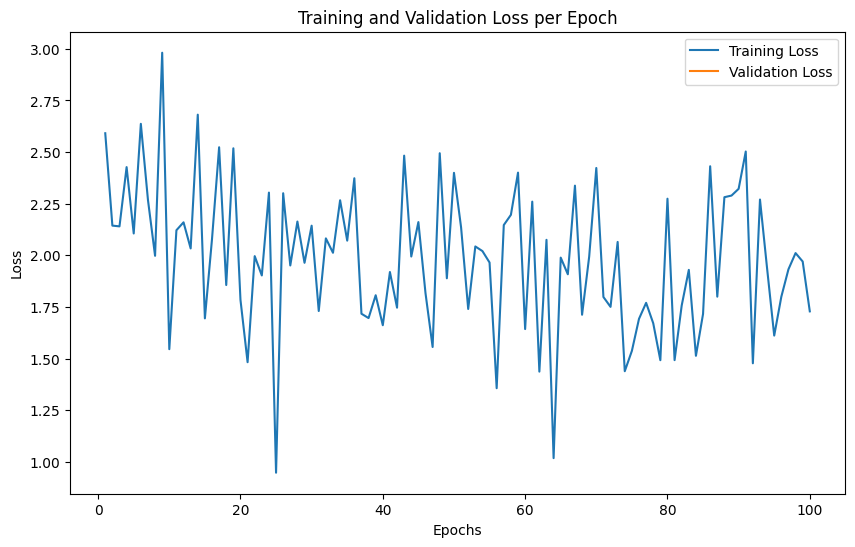

In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from transformers.data.data_collator import DataCollatorForLanguageModeling
from peft import prepare_model_for_int8_training, LoraConfig, get_peft_model

# Assuming all previous imports and model/tokenizer preparation is done

# Load and prepare your dataset here
# Make sure to split your data into training and validation sets if you haven't already
data = load_dataset("Abirate/english_quotes")
data = data.map(lambda samples: tokenizer(samples["quote"], truncation=True, padding="max_length"), batched=True)

# Split your data into training and validation sets if not already split
train_data = data["train"].train_test_split(test_size=0.1)

# Update the TrainingArguments
training_args = TrainingArguments(
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    warmup_steps=50,
    max_steps=100,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=1,
    output_dir="outputs",
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    num_train_epochs=3,  # Train for 3 epochs
)

# Create the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data["train"],
    eval_dataset=train_data["test"],  # Make sure to have a validation set for evaluation
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

# Train the model
trainer.train()

# After training, extract and plot the training and validation losses
training_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
validation_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Number of epochs should match the longer of the two lists
num_epochs = max(len(training_loss), len(validation_loss))
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))

# Plot Training Loss if available
if training_loss:
    plt.plot(epochs[:len(training_loss)], training_loss, label='Training Loss')

# Plot Validation Loss if available
if validation_loss:
    plt.plot(epochs[:len(validation_loss)], validation_loss, label='Validation Loss')

plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
batch = tokenizer("Two things are infinite: ", return_tensors="pt")

with torch.cuda.amp.autocast():
    output_tokens = model.generate(**batch, max_new_tokens=50)

print("\n\n", tokenizer.decode(output_tokens[0], skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1635: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(




 Two things are infinite:  The universe and human stupidity; and I'm not sure about the universe.  -Albert Einstein
I'm not sure about the universe either.


In [ ]:
batch = tokenizer("Imperfection is beauty, ", return_tensors="pt")

with torch.cuda.amp.autocast():
    output_tokens = model.generate(**batch, max_new_tokens=50)

print("\n\n", tokenizer.decode(output_tokens[0], skip_special_tokens=True))



 Imperfection is beauty,  Ugliness is beauty,   The world is not ugly.   It is merely human.   - Oscar Wilde
I love this quote.


In [ ]:
batch = tokenizer("Live as if you were to die tomorrow. ", return_tensors="pt")

with torch.cuda.amp.autocast():
    output_tokens = model.generate(**batch, max_new_tokens=100)

print("\n\n", tokenizer.decode(output_tokens[0], skip_special_tokens=True))



 Live as if you were to die tomorrow.  Learn as if you were to live forever.  -Mahatma Gandhi
I like this one. I'm going to use it.


In [ ]:
batch = tokenizer("So many books,  ", return_tensors="pt")

with torch.cuda.amp.autocast():
    output_tokens = model.generate(**batch, max_new_tokens=50)

print("\n\n", tokenizer.decode(output_tokens[0], skip_special_tokens=True))



 So many books,   so little time.
I'm in the same boat. I'm trying to read more, but I'm also trying to finish my current book.


In [ ]:
batch = tokenizer("Darkness cannot drive out darkness:  ", return_tensors="pt")

with torch.cuda.amp.autocast():
    output_tokens = model.generate(**batch, max_new_tokens=50)

print("\n\n", tokenizer.decode(output_tokens[0], skip_special_tokens=True))



 Darkness cannot drive out darkness:   Only light can do that.   Hate cannot drive out hate:   Only love can do that.   - Martin Luther King, Jr.
I love this quote. I'm going to use it.
